In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.deep7_model import *
import hierarchical_yolo.utils

In [2]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Other or Can't Tell
  5: Ehu
  6: Lehi
  7: Onaga
  8: Snapper
  9: Grouper
  10: Object
'''

deep7_hierarchy = {
    0: 8,
    1: 8,
    2: 9,
    3: 8,
    5: 8,
    6: 8,
    7: 8,
    4: 10,
    8: 10,
    9: 10
}

In [3]:
from ultralytics import settings

# View all settings
print(settings)

JSONDict("/home/noaa_brown/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/noaa_brown/datasets",
  "weights_dir": "/home/noaa_brown/hierarchical_yolo/weights",
  "runs_dir": "/home/noaa_brown/hierarchical_yolo/runs",
  "uuid": "2768c477e7938b5779aff75aed83103f60cf5680dbe7372dfa0b27c233b7d105",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true
}


In [4]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [5]:
DATA = '../data'
UPLOAD_URL = 'https://storage.googleapis.com/nmfs_odp_hq/nodd_tools/datasets/oceaneyes/category_balanced_sample/annotations.json'
DOWNLOAD_PATH = os.path.join(DATA, 'download')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'annotations.json')
YOLO_PATH = os.path.join(DOWNLOAD_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'annotations', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [6]:
uploaded_coco_file = requests.get(UPLOAD_URL)
with open(COCO_PATH, 'wb') as f:
    f.write(uploaded_coco_file.content)
    coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [7]:
def coco_category_dist(coco):
    import matplotlib.pyplot as plt
    cats, cnt = np.unique(list(map(lambda x: x['category_id'], coco.anns.values())), return_counts=True)
    cat_names = list(map(lambda cat_id: coco.cats[cat_id]['name'], cats))
    plt.bar(cat_names, cnt)
    for i, value in enumerate(cnt):
        plt.text(i, value + 0.5, str(value), ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

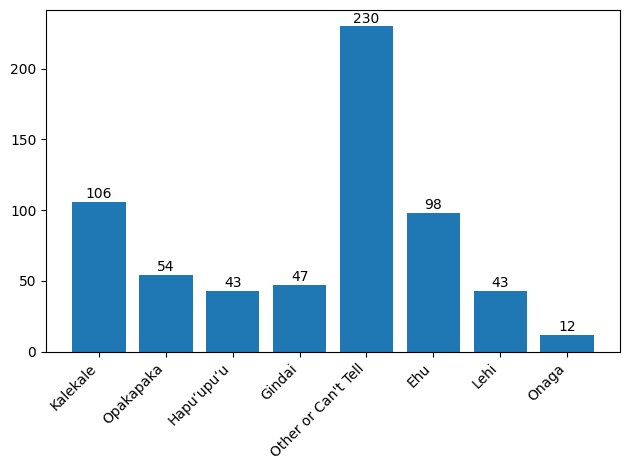

In [8]:
coco_category_dist(coco)

In [9]:
coco.info()

year: 2024
version: 0.1
description: https://www.zooniverse.org/projects/benjamin-dot-richards/oceaneyes/about/research
contributor: None
url: None
date_created: 2025-02-06T20:56:54.886937+00:00


In [10]:
pycocowriter.coco2yolo.coco2yolo(DOWNLOAD_PATH, YOLO_PATH)

Annotations /home/noaa_brown/hierarchical_yolo/data/download/annotations.json: 100%|██████████| 200/200 [00:00<00:00, 6332.32it/s]

COCO data converted successfully.
Results saved to /home/noaa_brown/hierarchical_yolo/notebooks/coco_converted
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
downloaded 0/200 images (t=0.0s)
downloaded 1/200 images (t=0.0s)
downloaded 2/200 images (t=0.0s)
downloaded 3/200 images (t=0.0s)
downloaded 4/200 images (t=0.0s)
downloaded 5/200 images (t=0.0s)
downloaded 6/200 images (t=0.0s)
downloaded 7/200 images (t=0.0s)
downloaded 8/200 images (t=0.0s)
downloaded 9/200 images (t=0.0s)
downloaded 10/200 images (t=0.0s)
downloaded 11/200 images (t=0.0s)
downloaded 12/200 images (t=0.0s)
downloaded 13/200 images (t=0.0s)
downloaded 14/200 images (t=0.0s)
downloaded 15/200 images (t=0.0s)
downloaded 16/200 images (t=0.0s)
downloaded 17/200 images (t=0.0s)
downloaded 18/200 images (t=0.0s)
downloaded 19/200 images (t=0.0s)
downloaded 20/200 images (t=0.0s)
downloaded 21/200 i

In [11]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [12]:
mlflow.autolog()

In [13]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [14]:
RETRAIN=True

In [15]:
if RETRAIN:
    results = model.train(
        data=YOLO_TRAIN_YAML, 
        epochs=2, imgsz=640, 
        device=devices, 
        batch=max(len(devices), 1),
        trainer=Deep7HierarchicalDetectionTrainer
    )

New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=detect, mode=train, model=../data/yolov8.yaml, data=../data/download/yolo_training_data/train.yaml, epochs=2, time=None, patience=100, batch=7, imgsz=640, save=True, save_

train: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 1 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1044.2±609.1 MB/s, size: 92.7 KB)


val: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 1 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to /home/noaa_brown/hierarchical_yolo/runs/detect/train130/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004921875), 63 bias(decay=0.0)
MLflow: logging run_id(576a4002396b4cd381cdf81b40a6cf07) to /home/noaa_brown/hierarchical_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/noaa_brown/hierarchical_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 14 dataloader workers
Logging results to /home/noaa_brown/hierarchical_yolo/runs/detect/train130
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      0.26G      2.339      6.081       1.58          2        640: 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


                   all        200        611    0.00102     0.0452    0.00186   0.000755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.283G      2.097      5.213      1.368         14        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


                   all        200        611    0.00165      0.106    0.00382    0.00107

2 epochs completed in 0.014 hours.
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train130/weights/last.pt, 6.2MB
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train130/weights/best.pt, 6.2MB

Validating /home/noaa_brown/hierarchical_yolo/runs/detect/train130/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce 

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


                   all        200        611    0.00165      0.105    0.00371    0.00106
              Kalekale         17        101   0.000154     0.0099   0.000129   5.18e-05
             Opakapaka         21         54    0.00258      0.333     0.0153    0.00298
            Hapuʻupuʻu         38         41    0.00175      0.122    0.00185   0.000772
                Gindai         10         46          0          0          0          0
   Other or Can't Tell         66        216    0.00696      0.116    0.00929    0.00372
                   Ehu         25         98   0.000948      0.143    0.00214   0.000705
                  Lehi         13         43   0.000771      0.116   0.000948   0.000273
                 Onaga          9         12          0          0          0          0
Speed: 4.2ms preprocess, 6.8ms inference, 0.0ms loss, 12.4ms postprocess per image
Results saved to /home/noaa_brown/hierarchical_yolo/runs/detect/train130
MLflow: results logged to /home/noaa_brown/

In [16]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [17]:
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt')).to('cuda')
trained_model.eval()

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [18]:
trained_model.overrides.get('imgsz', None)

In [19]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/download/yolo_training_data/annotations/images/20190926_194111_20190926.200434.274.016255.jpg'

In [20]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)
prediction = next(predictions)
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 1., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 1.,
        5., 5., 5., 5., 5., 5., 2., 5., 4., 5., 5., 4., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 2., 5., 5., 5., 3., 4., 3., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 5., 5., 5., 5., 5., 2., 5., 5., 5., 5., 5., 5., 2., 5., 5., 5.,
        5., 2., 5., 5., 5., 5., 2., 5., 5., 3., 5., 5., 5., 5., 5., 1., 5., 4., 2., 5., 5., 5., 2., 5., 5., 5., 4., 5., 5., 5., 5., 4., 5., 5., 1., 5., 2., 4., 2., 4., 4., 5., 5., 2., 5., 4., 4., 5., 4., 5., 5., 4., 2., 3., 5., 5., 4., 4., 4., 4., 5., 5., 5., 4., 2., 4., 4., 5., 5., 2., 4., 4., 5

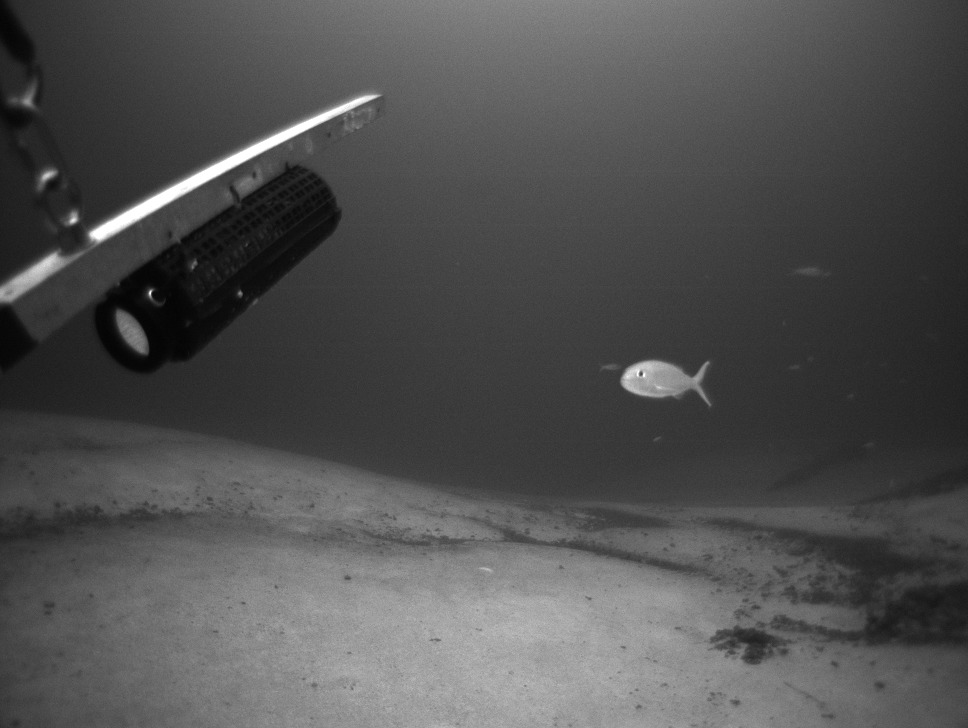

In [21]:
import torch
from PIL import Image

# Load and preprocess
image = Image.open(random_img).convert('RGB')
image

In [22]:
trained_model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(32

In [23]:
Deep7HierarchicalDetectionTrainer._hierarchy

{0: 4, 1: 4, 2: 4, 3: 4, 5: 4, 6: 4, 7: 4}

In [24]:
predicted_boxes, predicted_paths, predicted_path_scores = hierarchical_yolo.utils.hierarchical_predict(trained_model, Deep7HierarchicalDetectionTrainer._hierarchy, [image, image], cuda=True)

In [25]:
predicted_paths[0]

[[4, 5],
 [4, 5],
 [4, 2],
 [4, 2],
 [4, 5],
 [4, 2],
 [4, 5],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 3],
 [4, 2],
 [4, 2],
 [4, 5],
 [4, 3],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 2],
 [4, 3],
 [4, 2],
 [4, 5]]

In [26]:
predicted_path_scores[0]

[tensor([0.9998, 0.9380], device='cuda:0'),
 tensor([0.9754, 0.3322], device='cuda:0'),
 tensor([0.9620, 0.2416], device='cuda:0'),
 tensor([0.7223, 0.0963], device='cuda:0'),
 tensor([0.6285, 0.0858], device='cuda:0'),
 tensor([0.5819, 0.4560], device='cuda:0'),
 tensor([0.5678, 0.0778], device='cuda:0'),
 tensor([0.5210, 0.4980], device='cuda:0'),
 tensor([0.5107, 0.3956], device='cuda:0'),
 tensor([0.4978, 0.4765], device='cuda:0'),
 tensor([0.4864, 0.3858], device='cuda:0'),
 tensor([0.4851, 0.4361], device='cuda:0'),
 tensor([0.4833, 0.4144], device='cuda:0'),
 tensor([0.4609, 0.4149], device='cuda:0'),
 tensor([0.4576, 0.3485], device='cuda:0'),
 tensor([0.4494, 0.3098], device='cuda:0'),
 tensor([0.3478, 0.3143], device='cuda:0'),
 tensor([0.3376, 0.2889], device='cuda:0'),
 tensor([0.3145, 0.0416], device='cuda:0'),
 tensor([0.3100, 0.2193], device='cuda:0'),
 tensor([0.2969, 0.0697], device='cuda:0'),
 tensor([0.2933, 0.2598], device='cuda:0'),
 tensor([0.2923, 0.1616], device

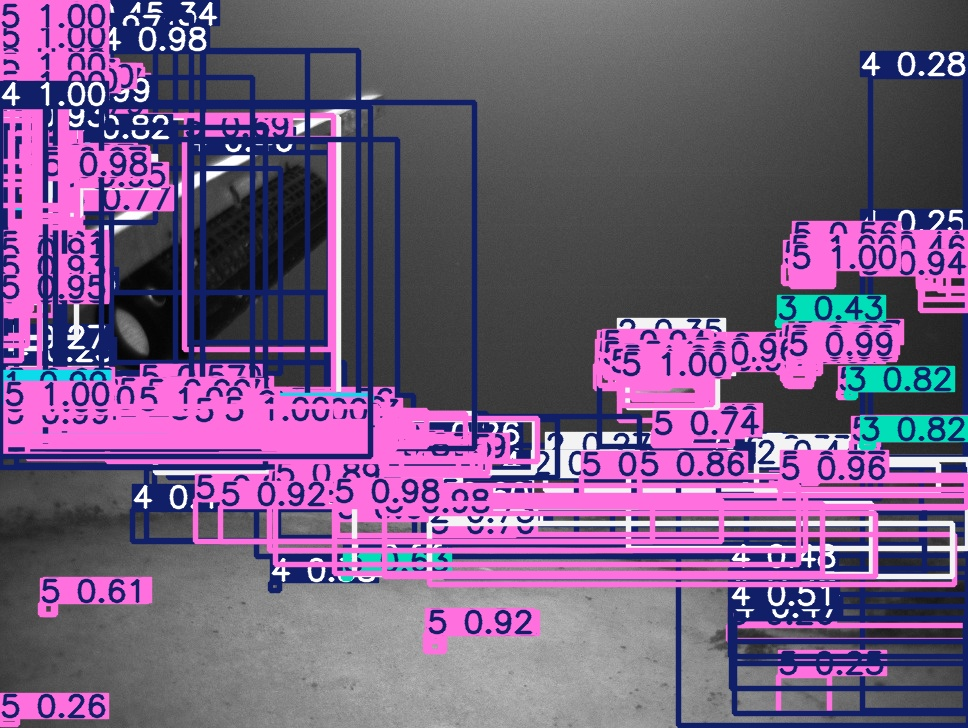

In [27]:
prediction.save('pickles.jpg')
from IPython.display import Image
Image(filename='pickles.jpg') 